In [9]:
import time
from typing import Any
from tqdm import tqdm

import gymnasium as gym
import numpy as np
from gymnasium.envs.registration import register
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from swarm.swarm_and_agent_env import SwarmAndAgentEnvConfig


In [2]:
register(
    id="SwarmAndAgentEnv",
    entry_point="swarm.swarm_and_agent_env:SwarmAndAgentEnv",
)

In [31]:
env = gym.make("SwarmAndAgentEnv")
observation, _ = env.reset()


dqn = nn.Sequential(nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 8))

optimizer = torch.optim.Adam(dqn.parameters(), lr=0.1)

gamma = 0.9

batch_size = 8


running_loss = []
avg_reward = []
agent_locations = []
for episode in range(1000):

    dqn.eval()
    replay_buffer = []
    states = []
    action_indices = []
    targets = []

    observation, _, _, _, _ = env.step(np.zeros((2,)))

    rewards = []

    for i in range(batch_size * 8 + 1):
        last_observation = torch.from_numpy(observation).flatten().unsqueeze(0).float()

        with torch.no_grad():
            out = dqn(last_observation)

        action_i = torch.argmax(out)
        if np.random.rand() < 0.1:
            action_i = np.random.randint(0, 8)

        angle = action_i * 2 * np.pi / 8
        action = np.array([np.cos(angle), np.sin(angle)])

        if i > 0:
            targets[-1] += gamma * out.max()

        observation, reward, _, _, _ = env.step(action)
        states.append(last_observation)
        action_indices.append(action_i)
        targets.append(reward)

        rewards.append(reward)
        agent_locations.append(env.agent.location)
    
  

    states = torch.concat(states[:-1])
    action_indices = torch.tensor(action_indices[:-1])
    targets = torch.tensor(targets[:-1])

    avg_reward.append(np.mean(rewards))

    print(avg_reward[-1])

    dqn.train()

    batch_indices = torch.randperm(len(states)).reshape(-1, batch_size)
    for batch in batch_indices:
        optimizer.zero_grad()

        s = states[batch]
        out = dqn(s)
        q = out[torch.arange(batch_size), action_indices[batch]]

        loss = nn.functional.mse_loss(q, targets[batch])
        loss.backward()

        optimizer.step()

        running_loss.append(loss.item())


2.3384615384615386
5.923076923076923
56.0
28.83076923076923
1.1846153846153846
3.923076923076923
31.50769230769231
0.07692307692307693
0.7384615384615385
2.5538461538461537
0.0
0.24615384615384617
28.43076923076923
20.96923076923077
0.7076923076923077
0.0
0.0
0.0
0.0
36.36923076923077
28.6
1.3384615384615384
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
32.784615384615385
1.676923076923077
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.09230769230769231
6.0
0.0
0.0
22.338461538461537
1.4
0.0
29.815384615384616
18.861538461538462
0.0
0.0
0.0
0.46153846153846156
49.246153846153845
27.369230769230768
0.0
0.8769230769230769
1.3076923076923077
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.8307692307692305
5.184615384615385
0.0
0.0
0.0
0.0
0.0
22.553846153846155
0.5384615384615384
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.030769230769231
11.553846153846154
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2923076923076923
4.046153846153846
0.12307692307692308
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7230769230769231
7.1692307692307695
20.476923

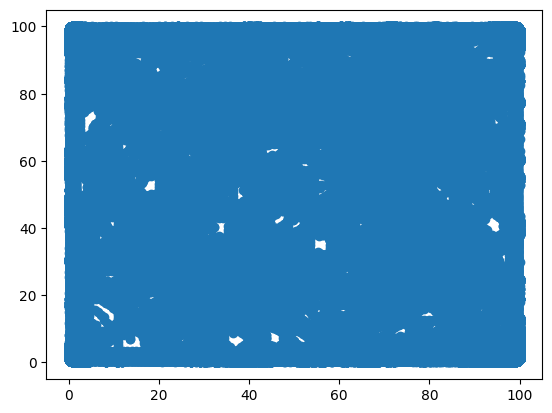

In [35]:
x, y=np.array(agent_locations).T
plt.scatter(x,y)

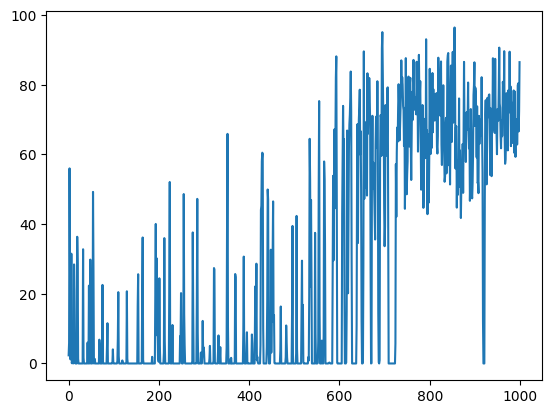

In [39]:
plt.plot(avg_reward)

In [33]:
torch.save(dqn.state_dict(), 'dqn1_state')